# Example 1: Basic usage


Fisrt of all, we need to install Docker/Docker Desktop.

- [How to install Docker on Linux?](https://envdes.github.io/clmu-app/container/install_docker.html)
- [How to install Docker Desktop](https://www.docker.com/products/docker-desktop/)
  
Platform: arm64/amd64


In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt



Here we use the `RUN_TYPE= "branch"` to avoid the repeated spinup phases.

The case (`usp_spinup`) is run for 10 years to spinup the model.

How to get `usp_spinup` ?

```python
usp_spinup = usp.run(
            case_name = "usp_spinup", 
            SURF="surfdata.nc",
            FORCING="forcing.nc",
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "10",
            RUN_TYPE= "coldstart",
        )
usp_spinup
```

In [2]:
%%time
# initialize
usp = usp_clmu()
usp_london = usp.run(
            case_name = "example1", 
            SURF="surfdata.nc",
            FORCING="forcing.nc",
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            hist_type = "'GRID','COLS'", # output type
        )
usp_london

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/inputfolder/usp
CPU times: user 1.16 s, sys: 328 ms, total: 1.49 s
Wall time: 3min 36s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/outputfolder/lnd/hist/example1_clm0_2024-11-23_14-53-19_clm.nc',
 '/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/outputfolder/lnd/hist/example1_clm1_2024-11-23_14-53-19_clm.nc']

---

**Plotting**

Note: ploting with time will need the `nc-time-axis` package, which can be installed by `pip install nc-time-axis` or `conda install nc-time-axis`

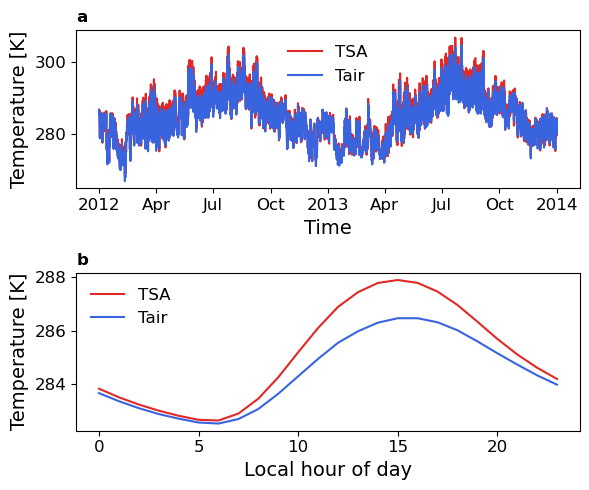

CPU times: user 1.92 s, sys: 512 ms, total: 2.44 s
Wall time: 3.32 s


In [3]:
%%time
ds_usp=usp.nc_view(usp_london[1]).isel(time=slice(2, None))
#ds_usp['time'] = ds_usp['time'].dt.round('min')
ds_usp_hour = ds_usp['TSA'].isel(gridcell=0).groupby('time.hour')
mean_tsa = ds_usp_hour.mean('time')
var_tsa = ds_usp_hour.var('time')

ds_usp_hour = ds_usp['TBOT'].isel(gridcell=0).groupby('time.hour')
mean_tbot = ds_usp_hour.mean('time')
var_tbot = ds_usp_hour.var('time')

fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(211)
ds_usp['TSA'].isel(gridcell=0).plot(ax=ax, label='TSA', color='#E02927')#["#E02927","#3964DF"]
ds_usp['TBOT'].isel(gridcell=0).plot(ax=ax, label='Tair', color='#3964DF')

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Temperature [K]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=12)

ax = fig.add_subplot(212)
mean_tsa.plot(ax=ax, label='TSA', color='#E02927')
mean_tbot.plot(ax=ax, label='Tair', color='#3964DF')
ax.set_xlabel('Local hour of day', fontsize=14)
ax.set_ylabel('Temperature [K]', fontsize=14)
ax.set_title('b', loc='left', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp.pdf', dpi=300)
plt.show()

**plot other urban variables**

**radiation balance**
$$Rnet(Q\text{*})=SWdown-SWup+LWdown-LWup$$

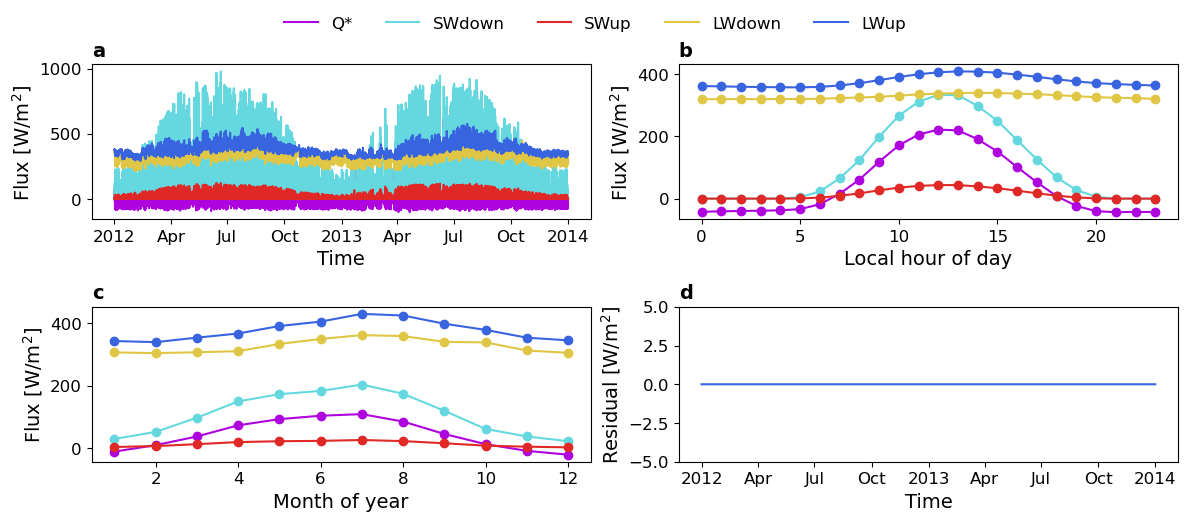

In [4]:
fig = plt.figure(figsize=(12, 5))

axs = fig.subplots(2, 2)

ds_usp_h = ds_usp[['Rnet','SWdown','SWup','LWdown','LWup']].isel(gridcell=0).groupby('time.hour')
h = ds_usp_h.mean('time')
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]

ds_usp_month = ds_usp[['Rnet','SWdown','SWup','LWdown','LWup']].isel(gridcell=0).groupby('time.month')
m = ds_usp_month.mean('time')

for i, var in enumerate(['Rnet','SWdown','SWup','LWdown','LWup']):
    if var == 'Rnet':
        label = 'Q*'
    else:
        label = var
    ds_usp[var].plot(ax=axs[0,0], label=label, color=color_list[i])
    m[var].plot(ax=axs[1,0], label=label, color=color_list[i], marker='o')
    h[var].plot(ax=axs[0,1], label=label, color=color_list[i], marker='o')

(ds_usp['Rnet'] - ds_usp['SWdown'] - ds_usp['LWdown']  + ds_usp['SWup'] + ds_usp['LWup'] ).plot(ax=axs[1,1], color='#3964DF')

xlabels = ['Time', 'Local hour of day', 'Month of year', 'Time']
ylabels = ['Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Residual [W/m$\mathrm{^{2}}$]']
titles = ['a', 'b', 'c', 'd']
for ax in axs.flat:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[1,1].set_ylim(-5,5)
fig.legend(['Q*','SWdown','SWup','LWdown','LWup'], 
           loc="upper center", frameon=False, ncol=5, 
           bbox_to_anchor=(0.5, 1.05), fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_rad.pdf', dpi=300, bbox_inches='tight')
plt.show()

**energy balance**
$$Q\text{*} + Qanth=Qle+Qh+Qstor$$
$$Q\text{*}=Rnet$$
$$Qanth=WASTEHEAT+URBAN_{HEAT}$$
$$Qstor=FGR+URBAN_{HEAT}-URBAN_{AC}$$

- Qanth: anthropogenic heat flux
- Qle: latent heat flux
- Qh: sensible heat flux
- Qstor: storage heat flux
- WASTEHEAT: wasteheat flux from heating and air conditioning flux
- URBAN_HEAT: urban heating flux
- URBAN_AC: heat flux from urban air conditioning 

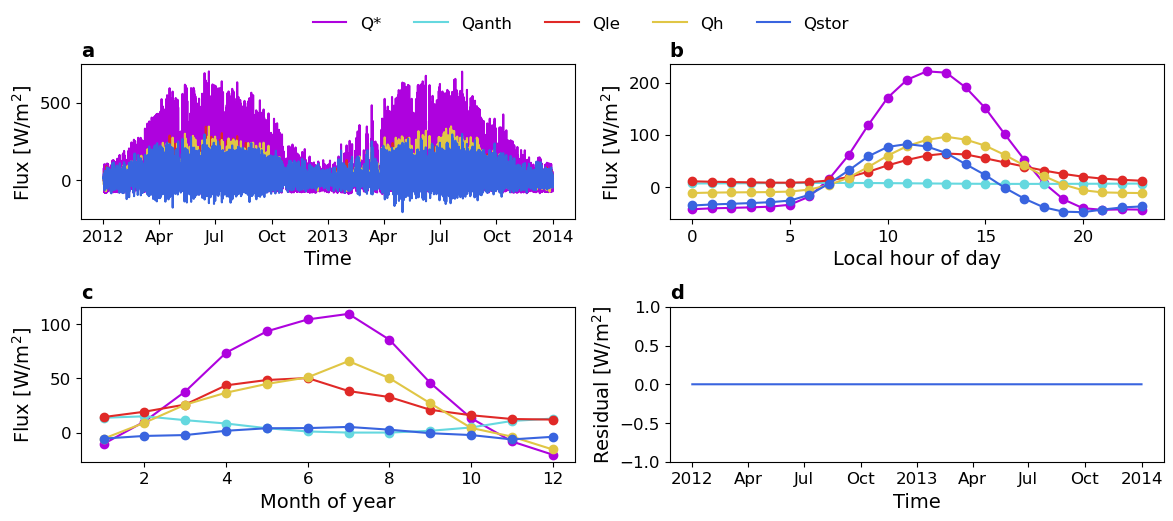

In [5]:
fig = plt.figure(figsize=(12, 5))

axs = fig.subplots(2, 2)

#ds_usp['Qanth'] = ds_usp['URBAN_HEAT'] + ds_usp['WASTEHEAT'] - ds_usp['EFLXBUILD']
ds_usp['Qanth'] = ds_usp['WASTEHEAT'] + ds_usp['URBAN_HEAT']
ds_usp['Qstor'] = ds_usp['FGR'] + ds_usp['URBAN_HEAT'] - ds_usp['URBAN_AC']
ds_usp_h = ds_usp[['Rnet','Qle', 'Qh', 'Qstor','Qanth']].isel(gridcell=0).groupby('time.hour')
h = ds_usp_h.mean('time')
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]

ds_usp_month = ds_usp[['Rnet','Qanth','Qle', 'Qh', 'Qstor']].isel(gridcell=0).groupby('time.month')
m = ds_usp_month.mean('time')

for i, var in enumerate(['Rnet','Qanth','Qle', 'Qh', 'Qstor']):
    if var == 'Rnet':
        label = 'Q*'
    else:
        label = var
    ds_usp[var].plot(ax=axs[0,0], label=label, color=color_list[i])
    m[var].plot(ax=axs[1,0], label=label, color=color_list[i], marker='o')
    h[var].plot(ax=axs[0,1], label=label, color=color_list[i], marker='o')

(ds_usp['Rnet']+ds_usp['Qanth'] - ds_usp['Qle'] - ds_usp['Qh'] - ds_usp['Qstor']).plot(ax=axs[1,1], color='#3964DF')

xlabels = ['Time', 'Local hour of day', 'Month of year', 'Time']
ylabels = ['Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Residual [W/m$\mathrm{^{2}}$]']
titles = ['a', 'b', 'c', 'd']
for ax in axs.flat:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[1,1].set_ylim(-1,1)
fig.legend(['Q*','Qanth','Qle','Qh','Qstor'], loc='upper center', frameon=False, ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_energy.pdf', dpi=300, bbox_inches='tight')
plt.show()

**buiding energy consumption**

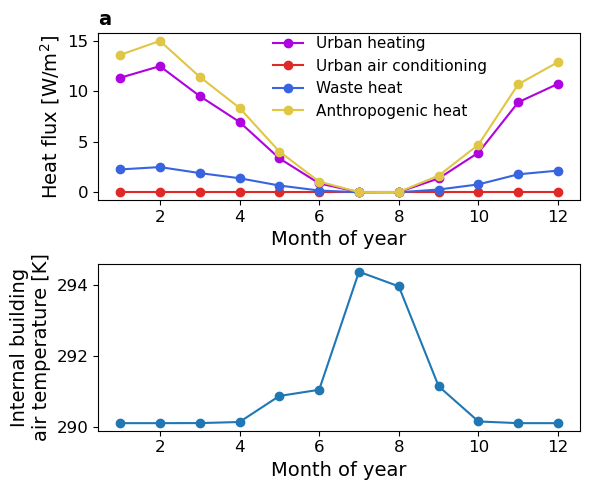

In [6]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
color_list = ["#AE02DE","#E02927","#3964DF"]
tot = ds_usp.sel(gridcell=0)
tot['TOTQANTH'] = tot['URBAN_HEAT'] + tot['WASTEHEAT']
tot = tot[['URBAN_HEAT','URBAN_AC','WASTEHEAT', 'TOTQANTH']].groupby('time.month').mean('time')
tot['URBAN_HEAT'].plot(ax=ax, label='Urban heating', marker='o', color=color_list.pop(0))
tot['URBAN_AC'].plot(ax=ax, label='Urban air conditioning', marker='o', color=color_list.pop(0))
tot['WASTEHEAT'].plot(ax=ax, label='Waste heat', marker='o', color=color_list.pop(0))
tot['TOTQANTH'].plot(ax=ax, label='Anthropogenic heat', marker='o', color='#E0C645')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Heat flux [W/m$\mathrm{^{2}}$]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=11, loc=(0.35,0.45))

ax = fig.add_subplot(212)
tot = ds_usp.sel(gridcell=0)['TBUILD'].groupby('time.month').mean('time').plot(ax=ax, marker='o')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Internal building\nair temperature [K]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_urban_bem.pdf', dpi=300)
plt.show()

**column level temperature**

In [7]:
ds_usp_col=usp.nc_view(usp_london[0]).isel(time=slice(2, None))
ds_usp_col

<xarray.Dataset> Size: 134MB
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 1, time: 35086,
                         hist_interval: 2, lndgrid: 1, gridcell: 1,
                         landunit: 2, column: 6, pft: 6, levsoi: 20)
Coordinates:
  * levgrnd             (levgrnd) float32 100B 0.01 0.04 0.09 ... 28.87 42.0
  * levlak              (levlak) float32 40B 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 4B 1.0
  * time                (time) datetime64[ns] 281kB 2012-01-01T01:30:00 ... 2...
Dimensions without coordinates: hist_interval, lndgrid, gridcell, landunit,
                                column, pft, levsoi
Data variables: (12/121)
    mcdate              (time) int32 140kB ...
    mcsec               (time) int32 140kB ...
    mdcur               (time) int32 140kB ...
    mscur               (time) int32 140kB ...
    nstep               (time) int32 140kB ...
    time_bounds         (time, hist_interval) datetime64[ns] 561kB ...
    ...                  ...
    URBAN_AC            (time, column) float32 842kB ...
    URBAN_HEAT          (time, column) float32 842kB ...
    WASTEHEAT           (time, column) float32 842kB ...
    WBT                 (time, column) float32 842kB ...
    Wind                (time, column) float32 842kB ...
    ZWT                 (time, column) float32 842kB ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 11/23/24 14:50:56
    source:                                    Community Land Model CLM4.0
    hostname:                                  clmu-app
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          minute_30
    Time_constant_3Dvars_filename:             ./example1.clm2.h0.2012-01-01-...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

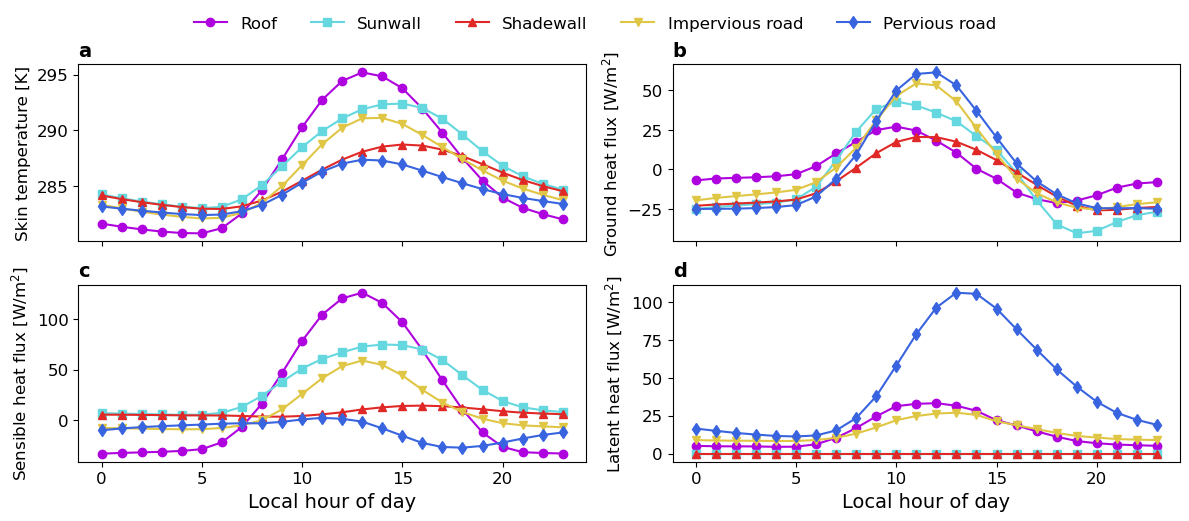

In [ ]:
ds_usp_col=usp.nc_view(usp_london[0])
ds_usp_col = ds_usp_col.assign_coords({'column':ds_usp_col['cols1d_itype_col']})
fig = plt.figure(figsize=(12, 5))
var_list = ['TSKIN','FGR','FSH','EFLX_LH_TOT']
title = ['a', 'b', 'c', 'd']
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]
ylabel = {
    'TSKIN':'Skin temperature [K]',
    'FGR':'Ground heat flux [W/m$\mathrm{^{2}}$]',
    'FSH':'Sensible heat flux [W/m$\mathrm{^{2}}$]',
    'EFLX_LH_TOT':'Latent heat flux [W/m$\mathrm{^{2}}$]'
}
markers = ['o', 's', '^', 'v', 'd']
for i, var in enumerate(var_list):
    ax = fig.add_subplot(2, 2, i+1)
    
    for col in range(71,76):
        #ds_usp_col[var].sel(column=col).resample(time='M').mean()\
        ds_usp_col[var].sel(column=col).groupby('time.hour').mean('time')\
            .plot(ax=ax, color=color_list[col-71], marker=markers[col-71])
    
    ax.set_ylabel(ylabel[var], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if i in [2,3]:
        ax.set_xlabel('Local hour of day', fontsize=14)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    #ax.legend(frameon=False)
    ax.set_title('')
    ax.set_title(title[i], loc='left', fontweight='bold', fontsize=14)

fig.legend(['Roof','Sunwall','Shadewall','Impervious road','Pervious road'], 
           loc='upper center', frameon=False, ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=12)
fig.tight_layout()
fig.savefig('figs/exp1_usp_urban_col.pdf', dpi=300, bbox_inches='tight')
plt.show()

**water balance**
$$residual = RAIN + SNOW- EVPA - Qs - Qsb- DelSWE- DelSoilMoist - DelIntercept$$

- RAIN: rain from atmosphere
- SNOW: snow from atmosphere
- EVPA: total evaporation. $EVPA=QVEGT+QVEGE+QSOIL$
- QVEGT: canopy transpiration
- QVEGE: canopy evaporation
- QSOIL: Ground evaporation (soil/snow evaporation + soil/snow sublimation - dew)
- Qs: total runoff. $Qs=QOVER+QH2OSFC$
- Qsb: subsurface drainage. $Qsb=QDRAI+QDRAI_PERCH$
- QDRAI: sub-surface drainage
- QDRAI_PERCH: perched wt drainage
- DelSWE: delta H2OSNO (snow depth (liquid water)) divided by time-step.
- DelSoilMoist: delta SOILH2O (soil moisture) divided by time-step. SOILH2O is the sum of column level SOILLIQ and SOILICE weighed by pervious road (see following code).
- DelIntercept: the delta intercept water of roof and pervious road divided by time-step



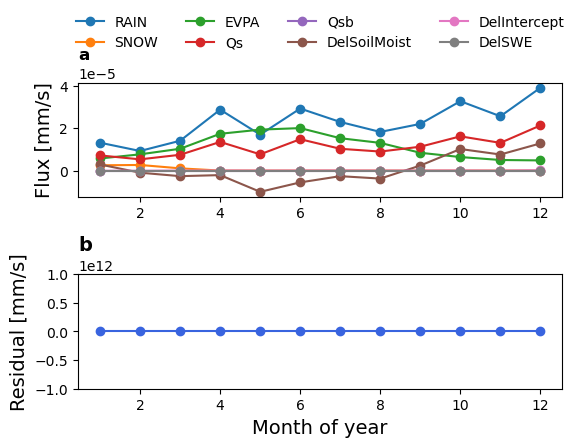

In [9]:
ds_usp=usp.nc_view(usp_london[1])#.isel(time=slice(2, None))
ds_usp_col=usp.nc_view(usp_london[0])#.isel(time=slice(2, None))
ds_usp['EVPA'] = ds_usp['QVEGT'] + ds_usp['QVEGE'] + ds_usp['QSOIL']
ds_usp['Qs'] = ds_usp['QOVER'] + ds_usp['QH2OSFC']
ds_usp['Qsb'] = ds_usp['QDRAI'] + ds_usp['QDRAI_PERCH']
ds_usp['DelSWE'] =ds_usp['H2OSNO'].diff('time')/1800

ds_usp_col = ds_usp_col.assign_coords({'column':ds_usp_col['cols1d_itype_col']})
roof_fra = ds_usp_col['cols1d_wtgcell'].sel(column=71).values
road_imp_fra = ds_usp_col['cols1d_wtgcell'].sel(column=74).values
road_pre_fra = ds_usp_col['cols1d_wtgcell'].sel(column=75).values
ds_usp_col['SOILH2O'] = (1 - roof_fra) \
                        * road_pre_fra / (road_pre_fra + road_imp_fra) \
                        * (ds_usp_col['SOILLIQ'].sel(column=75) + ds_usp_col['SOILICE'].sel(column=75))
#ds_usp_col['SOILH2O'] = road_pre_fra * (ds_usp_col['SOILLIQ'].sel(column=75) + ds_usp_col['SOILICE'].sel(column=75))
ds_usp_col['Intercept'] = roof_fra *\
                            (ds_usp_col['SOILLIQ'].sel(column=71) + ds_usp_col['SOILICE'].sel(column=71))\
                        + (1-roof_fra)*road_imp_fra/(road_pre_fra+road_imp_fra)\
                        * (ds_usp_col['SOILLIQ'].sel(column=74) + ds_usp_col['SOILICE'].sel(column=74))

ds_usp['DelSoilMoist'] = ds_usp_col['SOILH2O'].sum('levsoi').diff('time')/1800
ds_usp['DelIntercept'] = ds_usp_col['Intercept'].sum('levsoi').diff('time')/1800

ds_usp = ds_usp.isel(time=slice(2, None))
water_list = ['RAIN', 'SNOW' ,
              'EVPA', 'Qs', 'Qsb', 'DelSoilMoist', 'DelIntercept', 'DelSWE']
#color_list = ["#E02927","#3964DF","#E0C645","#AE02DE","#65D8DF"]
ds_usp_month = ds_usp[water_list].isel(gridcell=0).groupby('time.month')
tot = ds_usp_month.mean('time')

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
for i, var in enumerate(water_list):

    label = var
    tot[var].plot(ax=ax, marker='o', label=label,) 
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel(var, fontsize=14)

ax.set_xlabel('')
ax.set_ylabel('Flux [mm/s]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold')
ax.legend(frameon=False, fontsize=10, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.70))

ax = fig.add_subplot(212)

residual = ds_usp['RAIN'] + ds_usp['SNOW'] \
            - ds_usp['EVPA'] - ds_usp['Qs'] - ds_usp['Qsb'] \
            - ds_usp['DelSWE'] \
            - ds_usp['DelSoilMoist'] - ds_usp['DelIntercept']

residual.groupby('time.month').mean('time').plot(ax=ax, marker='o', label='Residual', color='#3964DF')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Residual [mm/s]', fontsize=14)

ax.set_title('b', loc='left', fontweight='bold', fontsize=14)

ax.set_ylim(-1e12,1e12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_water.pdf', dpi=300, bbox_inches='tight')
plt.show()

**human heat stress index**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TSA [279.59 278.31 280.55 282.82 286.78 289.17 292.96 292.77 289.01 286.21
 281.78 280.45]
HIA [ 6.44  5.16  7.44  9.72 13.81 16.44 20.41 20.58 16.11 13.09  8.63  7.3 ]
SWBGT [10.56  9.43 10.98 12.51 15.65 17.64 20.53 20.55 17.61 15.81 12.2  11.27]
WBT [ 4.19  2.6   4.45  6.15  9.68 11.9  14.66 14.77 11.9  10.3   6.2   5.17]
HUMIDEX [ 5.08  3.23  5.87  8.48 13.7  16.99 21.82 21.82 16.91 13.82  7.83  6.26]


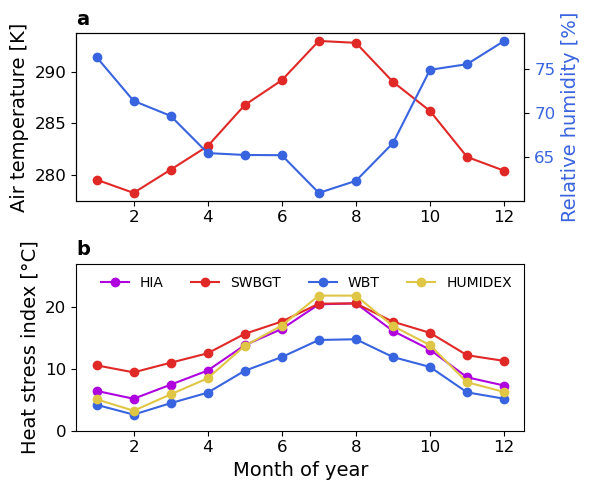

In [10]:
fig = plt.figure(figsize=(6, 5))
dis_list = ['HIA','SWBGT','WBT', 'HUMIDEX']

ax = fig.add_subplot(211)
mean = ds_usp['TSA'].sel(gridcell=0).groupby('time.month').mean('time')
std = ds_usp['TSA'].sel(gridcell=0).groupby('time.month').std('time')
mean.plot(ax=ax, marker='o',color='#E02927')
#ax.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color='#E02927')
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Air temperature [K]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold', fontsize=14)
ax.legend(frameon=False)
print('TSA', mean.values.round(2))

ax2 = ax.twinx()
mean = ds_usp['RH2M'].sel(gridcell=0).groupby('time.month').mean('time')
mean.plot(ax=ax2, marker='o', color='#3964DF')#color_list = ["#E02927","#3964DF"]
std = ds_usp['RH2M'].sel(gridcell=0).groupby('time.month').std('time')
#ax2.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color='#3964DF')
ax2.set_ylabel('Relative humidity [%]', color='#3964DF', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#3964DF', labelsize=12)

ax = fig.add_subplot(212)
color_list = ["#AE02DE","#E02927","#3964DF","#E0C645"]
tot = ds_usp[dis_list].sel(gridcell=0)

for var in dis_list:
    mean = tot[var].groupby('time.month').mean('time')
    std = tot[var].groupby('time.month').std('time')
    color = color_list.pop(0)
    mean.plot(ax=ax, label=var, marker='o', color=color)
    print(var, mean.values.round(2))
    #ax.plot(mean, label=var, marker='o', color=color_list.pop(0))
    #ax.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color=color)

ax.set_ylim(0, 27)
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Heat stress index [°C]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('b', loc='left', fontweight='bold', fontsize=14)
ax.legend(frameon=False, fontsize=10, ncol=4, loc='upper right')

plt.tight_layout()
plt.savefig('figs/exp1_usp_urban_heat_stress.pdf', dpi=300)
plt.show()

**clean up the case files**

In [11]:
usp.case_clean() 

# when you using ups.run(crun_type='usp-exec') --> see warmup section
# the case files in ./workdir/ouptutfolder/your_case, ./workdir/logfolder/your_case, 
# and ./workdir/inputfoler/usp will be removed.

# when you using ups.run(crun_type='run') or ups.run(), the default crun_type is 'run'
# only ./workdir/inputfoler/usp will be removed.